<a href="https://colab.research.google.com/github/dokin0802/SinGAN/blob/master/pa_6default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [23]:
dir_ = Path('/content/drive/MyDrive/architecture_aug/ex2/augf2')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/architecture_aug/ex2/au...,Deconstructivism
1,/content/drive/MyDrive/architecture_aug/ex2/au...,Baroque
2,/content/drive/MyDrive/architecture_aug/ex2/au...,Gothic
3,/content/drive/MyDrive/architecture_aug/ex2/au...,Baroque
4,/content/drive/MyDrive/architecture_aug/ex2/au...,Gothic


In [24]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 1500

Number of different labels: 6

Labels: ['Deconstructivism' 'Baroque' 'Gothic' 'Romanesque' 'International'
 'Postmodern']


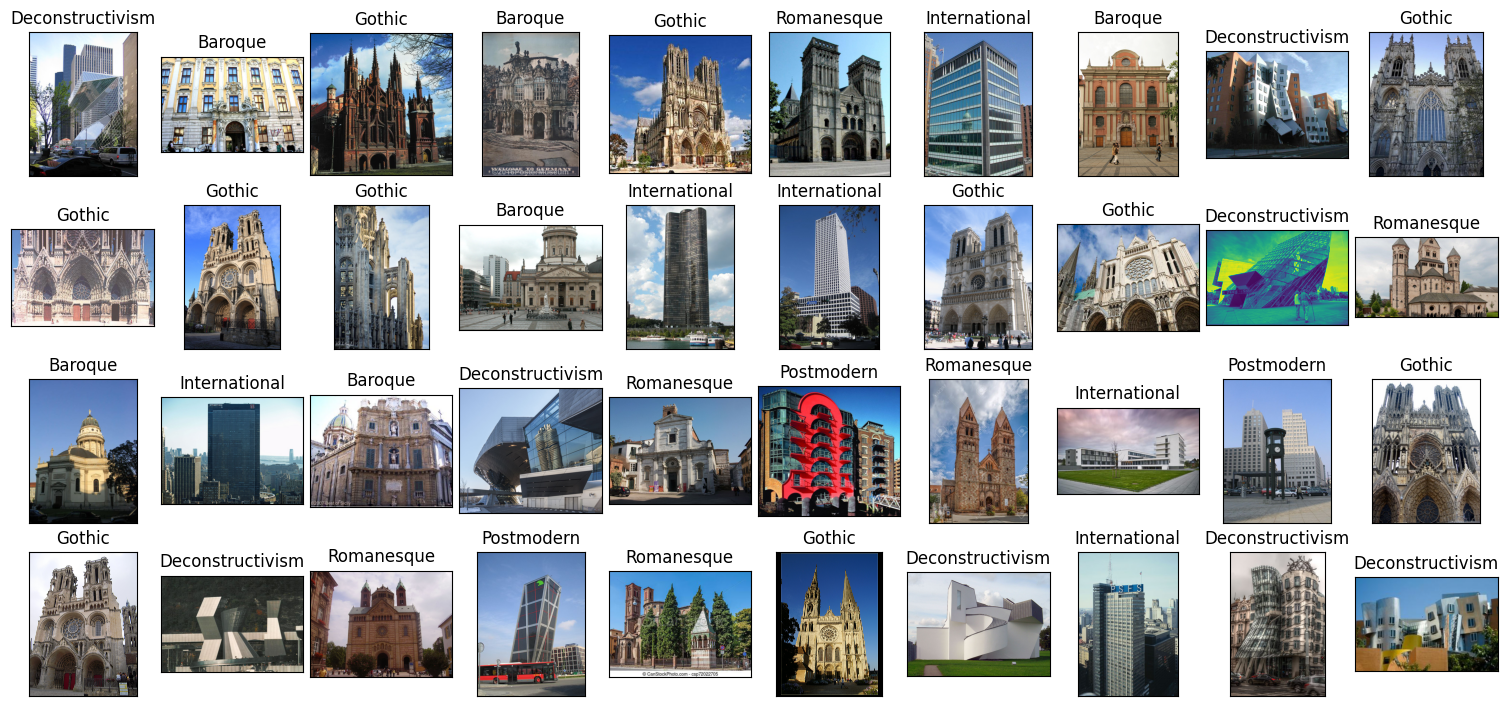

In [25]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

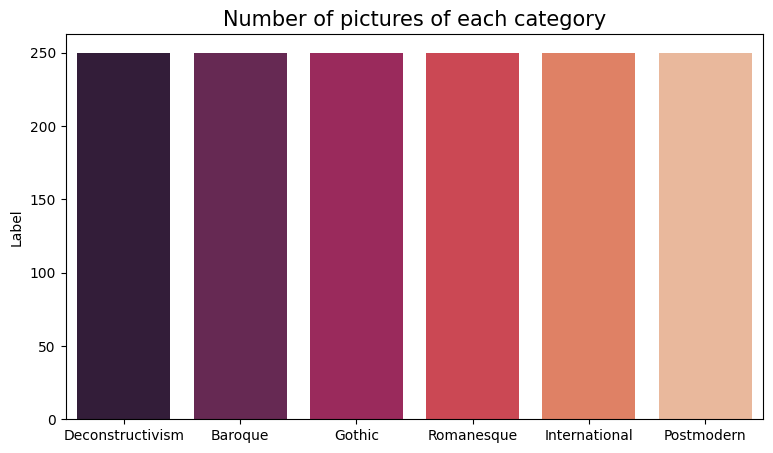

In [26]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [27]:
train_df =df

dir_ = Path('/content/drive/MyDrive/architecture_small/test')
filepaths = list(dir_.glob(r'**/*.jpg'))
test_df = proc_img(filepaths)

In [28]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.20)

train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/architecture_aug/ex2/augf2',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('/content/drive/MyDrive/architecture_aug/ex2/augf2',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 1200 images belonging to 6 classes.
Found 300 images belonging to 6 classes.


In [29]:

test_datagen =  ImageDataGenerator(rescale=1/255)

test_gen  = test_datagen.flow_from_directory('/content/drive/MyDrive/architecture_small/test',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 300 images belonging to 6 classes.


In [30]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.20
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [31]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 8로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [40]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
start = perf_counter()
history = model.fit(train_images,validation_data=val_images,epochs=10)
duration = perf_counter() - start
print(duration)

Found 1200 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Epoch 1/50
38/38 [==============================] - 31s 553ms/step - loss: 1.0047 - accuracy: 0.6042 - val_loss: 0.6546 - val_accuracy: 0.6967
Epoch 2/50
38/38 [==============================] - 18s 475ms/step - loss: 0.5198 - accuracy: 0.7983 - val_loss: 0.5085 - val_accuracy: 0.7900
Epoch 3/50
38/38 [==============================] - 18s 467ms/step - loss: 0.3904 - accuracy: 0.8500 - val_loss: 0.5170 - val_accuracy: 0.7833
Epoch 4/50
38/38 [==============================] - 18s 463ms/step - loss: 0.3125 - accuracy: 0.8867 - val_loss: 0.5549 - val_accuracy: 0.7733
Epoch 5/50
38/38 [==============================] - 18s 466ms/step - loss: 0.2347 - accuracy: 0.9233 - val_loss: 0.4354 - val_accuracy: 0.8333
Epoch 6/50
38/38 [==============================] - 18s 461ms/step - loss: 0.1646 - accuracy: 0.9450 - v

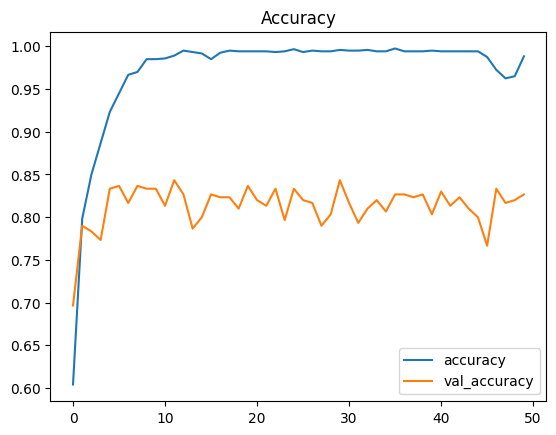

In [41]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

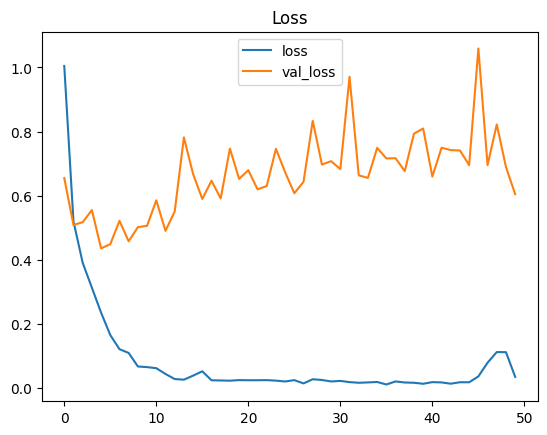

In [42]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [43]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 6s 321ms/step
Accuracy on the test set: 72.67%


In [44]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                  precision    recall  f1-score   support

         Baroque       0.91      0.96      0.93        50
Deconstructivism       0.77      0.74      0.76        50
          Gothic       0.71      0.78      0.74        50
   International       0.65      0.62      0.63        50
      Postmodern       0.62      0.58      0.60        50
      Romanesque       0.69      0.68      0.69        50

        accuracy                           0.73       300
       macro avg       0.72      0.73      0.72       300
    weighted avg       0.72      0.73      0.72       300



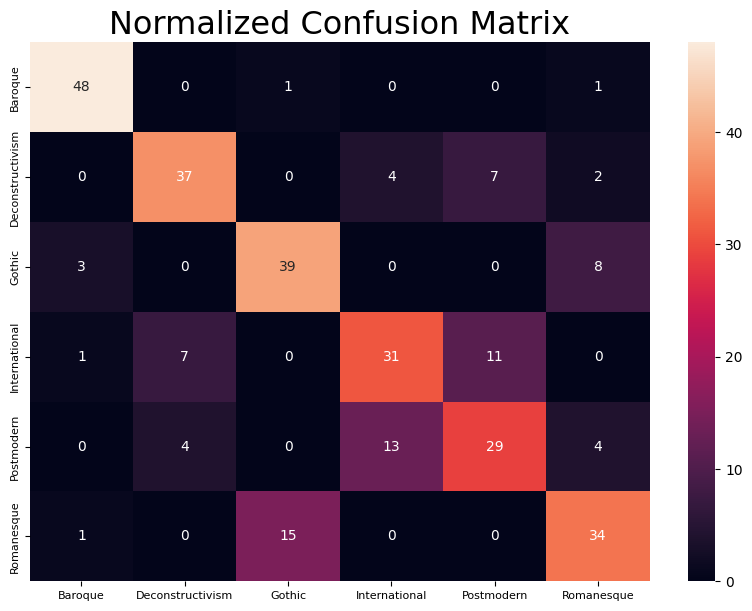

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred)#, normalize='true')



plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

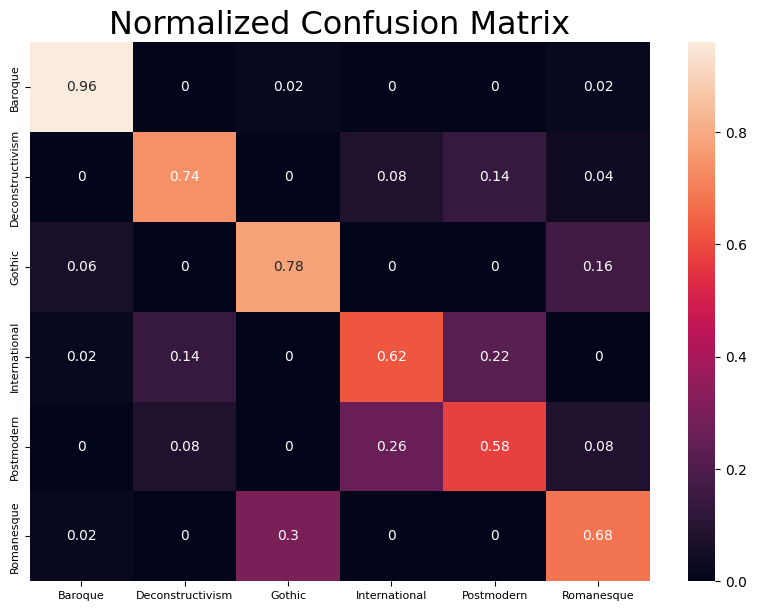

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')



plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
model()

In [20]:
import shutil
shutil.rmtree('/content/drive/MyDrive/architecture_aug/ex2/augf2/.ipynb_checkpoints')

In [ ]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet121)
history = model.fit(train_images,validation_data=val_images,epochs=4)

Found 1200 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Epoch 1/4
38/38 [==============================] - 19s 323ms/step - loss: 1.0030 - accuracy: 0.5892 - val_loss: 0.6601 - val_accuracy: 0.7000
Epoch 2/4
38/38 [==============================] - 10s 273ms/step - loss: 0.5027 - accuracy: 0.8075 - val_loss: 0.6114 - val_accuracy: 0.7467
Epoch 3/4
38/38 [==============================] - 10s 274ms/step - loss: 0.3820 - accuracy: 0.8575 - val_loss: 0.4939 - val_accuracy: 0.7900
Epoch 4/4
38/38 [==============================] - 10s 273ms/step - loss: 0.3442 - accuracy: 0.8658 - val_loss: 0.4852 - val_accuracy: 0.8133


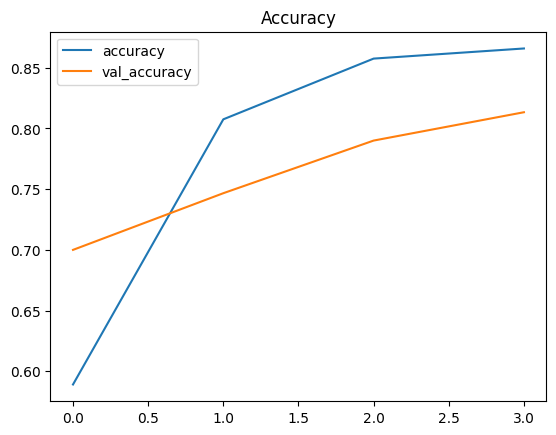

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

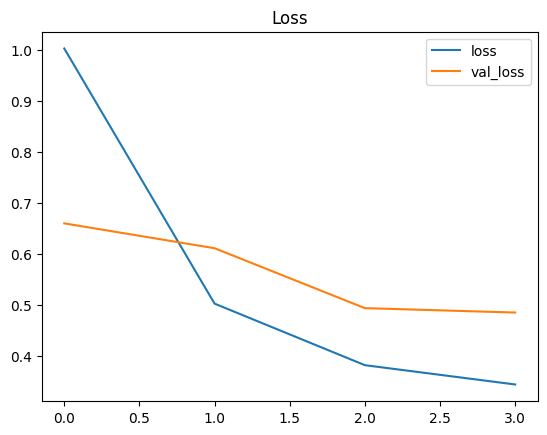

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 5s 312ms/step
Accuracy on the test set: 62.00%


In [ ]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                  precision    recall  f1-score   support

         Baroque       0.59      1.00      0.74        50
Deconstructivism       0.66      0.80      0.72        50
          Gothic       0.75      0.18      0.29        50
   International       0.81      0.52      0.63        50
      Postmodern       0.52      0.56      0.54        50
      Romanesque       0.59      0.66      0.62        50

        accuracy                           0.62       300
       macro avg       0.65      0.62      0.59       300
    weighted avg       0.65      0.62      0.59       300



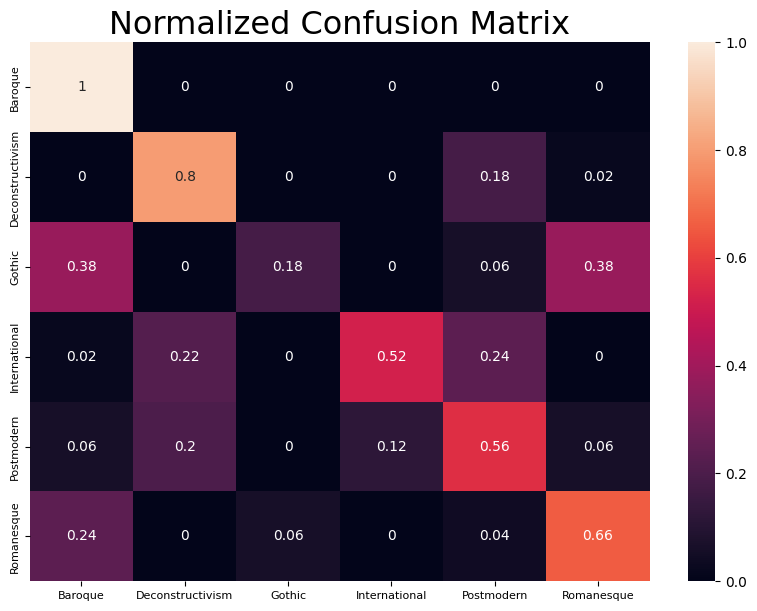

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')



plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.Xception)
history = model.fit(train_images,validation_data=val_images,epochs=4)

Found 1200 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Epoch 1/4
38/38 [==============================] - 15s 296ms/step - loss: 0.9160 - accuracy: 0.6400 - val_loss: 0.5952 - val_accuracy: 0.7333
Epoch 2/4
38/38 [==============================] - 10s 271ms/step - loss: 0.5201 - accuracy: 0.7800 - val_loss: 0.5789 - val_accuracy: 0.7367
Epoch 3/4
38/38 [==============================] - 10s 274ms/step - loss: 0.4492 - accuracy: 0.8258 - val_loss: 0.5694 - val_accuracy: 0.7467
Epoch 4/4
38/38 [==============================] - 10s 271ms/step - loss: 0.3330 - accuracy: 0.8683 - val_loss: 0.5584 - val_accuracy: 0.7700


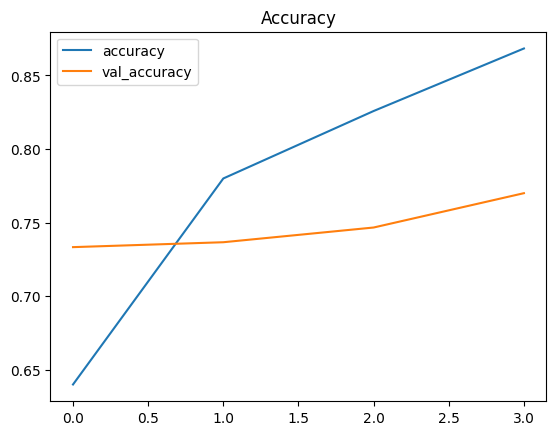

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

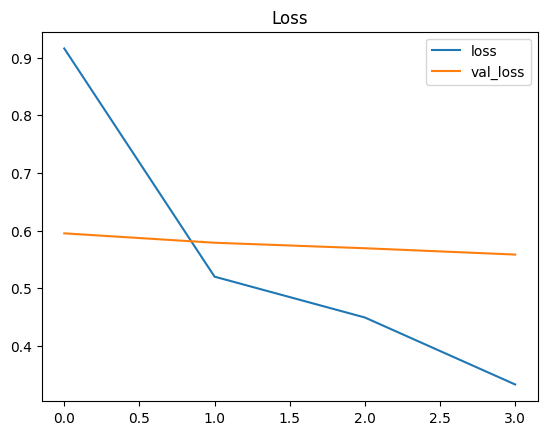

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 4s 316ms/step
Accuracy on the test set: 60.67%


In [ ]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                  precision    recall  f1-score   support

         Baroque       0.91      0.78      0.84        50
Deconstructivism       0.68      0.76      0.72        50
          Gothic       0.67      0.04      0.08        50
   International       0.80      0.40      0.53        50
      Postmodern       0.53      0.70      0.60        50
      Romanesque       0.45      0.96      0.61        50

        accuracy                           0.61       300
       macro avg       0.67      0.61      0.56       300
    weighted avg       0.67      0.61      0.56       300



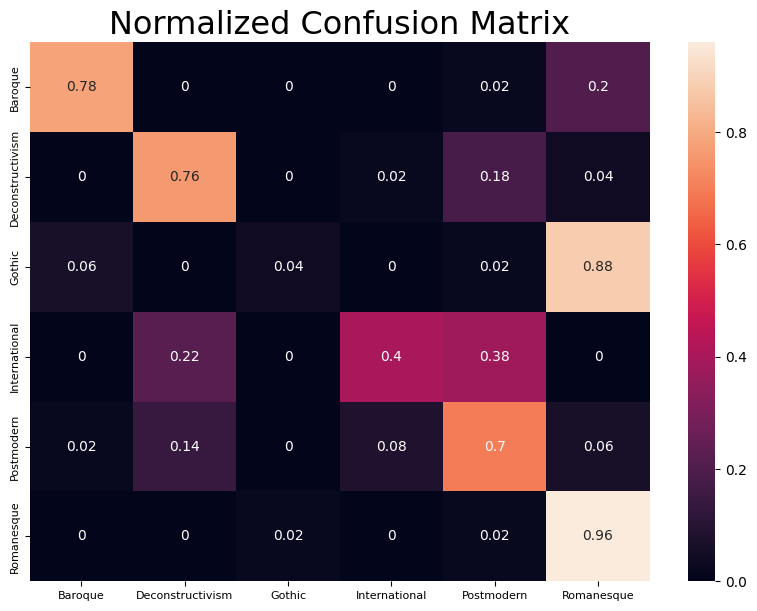

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')



plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.ResNet152V2)
history = model.fit(train_images,validation_data=val_images,epochs=4)

Found 1200 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Epoch 1/4
38/38 [==============================] - 24s 347ms/step - loss: 0.8844 - accuracy: 0.6533 - val_loss: 0.5993 - val_accuracy: 0.7733
Epoch 2/4
38/38 [==============================] - 10s 274ms/step - loss: 0.3998 - accuracy: 0.8358 - val_loss: 0.5415 - val_accuracy: 0.7600
Epoch 3/4
38/38 [==============================] - 10s 273ms/step - loss: 0.2202 - accuracy: 0.9175 - val_loss: 0.5133 - val_accuracy: 0.8067
Epoch 4/4
38/38 [==============================] - 10s 273ms/step - loss: 0.1233 - accuracy: 0.9658 - val_loss: 0.5676 - val_accuracy: 0.8033


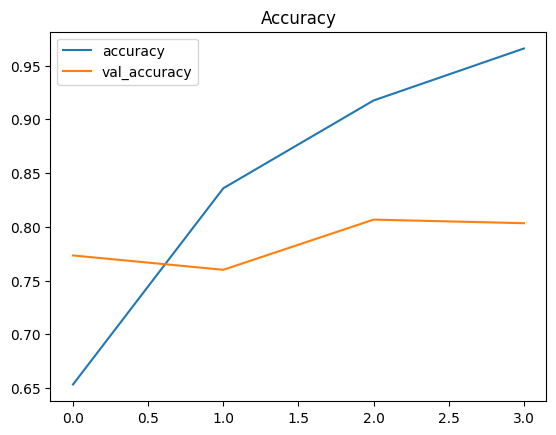

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

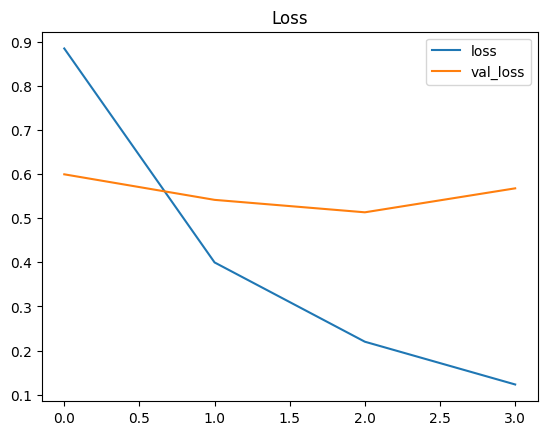

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 6s 317ms/step
Accuracy on the test set: 69.33%


In [ ]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                  precision    recall  f1-score   support

         Baroque       0.90      0.94      0.92        50
Deconstructivism       0.65      0.78      0.71        50
          Gothic       0.85      0.34      0.49        50
   International       0.88      0.56      0.68        50
      Postmodern       0.57      0.66      0.61        50
      Romanesque       0.56      0.88      0.69        50

        accuracy                           0.69       300
       macro avg       0.74      0.69      0.68       300
    weighted avg       0.74      0.69      0.68       300



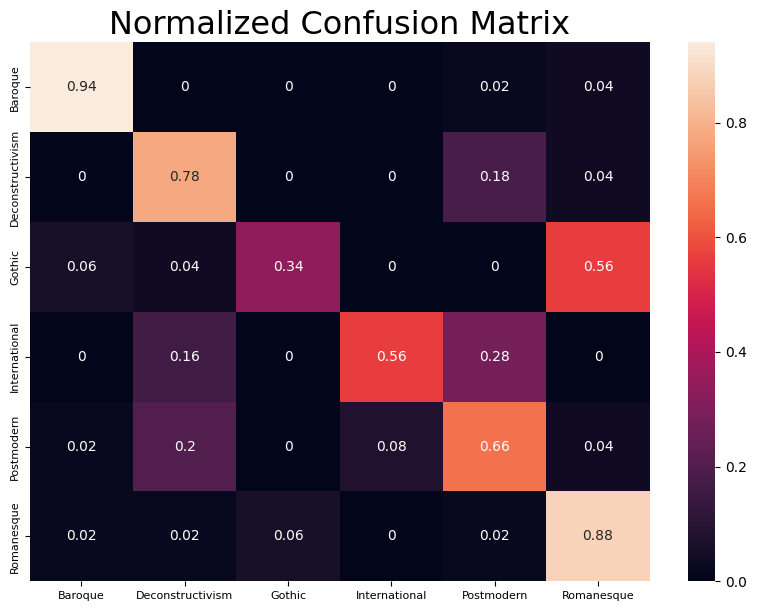

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')



plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.InceptionV3)
history = model.fit(train_images,validation_data=val_images,epochs=4)

Found 1200 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Epoch 1/4
38/38 [==============================] - 16s 309ms/step - loss: 1.0242 - accuracy: 0.5642 - val_loss: 0.6598 - val_accuracy: 0.7300
Epoch 2/4
38/38 [==============================] - 10s 273ms/step - loss: 0.5286 - accuracy: 0.7958 - val_loss: 0.5913 - val_accuracy: 0.7600
Epoch 3/4
38/38 [==============================] - 10s 275ms/step - loss: 0.3907 - accuracy: 0.8500 - val_loss: 0.6923 - val_accuracy: 0.7467
Epoch 4/4
38/38 [==============================] - 10s 276ms/step - loss: 0.3224 - accuracy: 0.8842 - val_loss: 0.5594 - val_accuracy: 0.7767


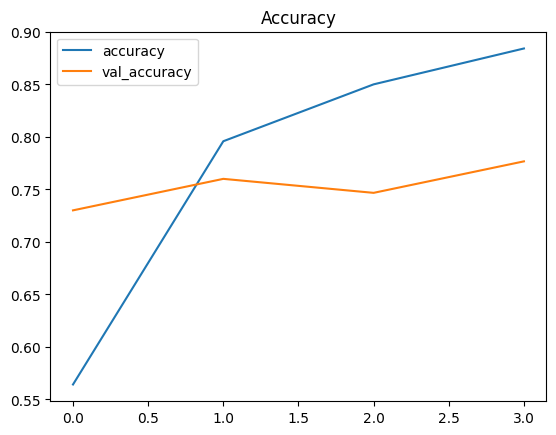

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

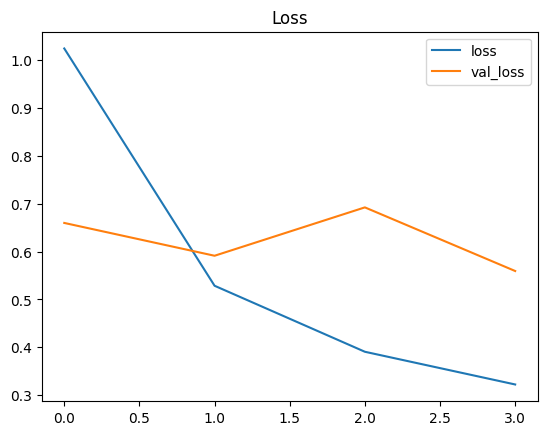

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 5s 316ms/step
Accuracy on the test set: 61.33%


In [ ]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                  precision    recall  f1-score   support

         Baroque       0.88      0.88      0.88        50
Deconstructivism       0.58      0.84      0.69        50
          Gothic       0.80      0.08      0.15        50
   International       0.71      0.58      0.64        50
      Postmodern       0.56      0.40      0.47        50
      Romanesque       0.47      0.90      0.62        50

        accuracy                           0.61       300
       macro avg       0.67      0.61      0.57       300
    weighted avg       0.67      0.61      0.57       300



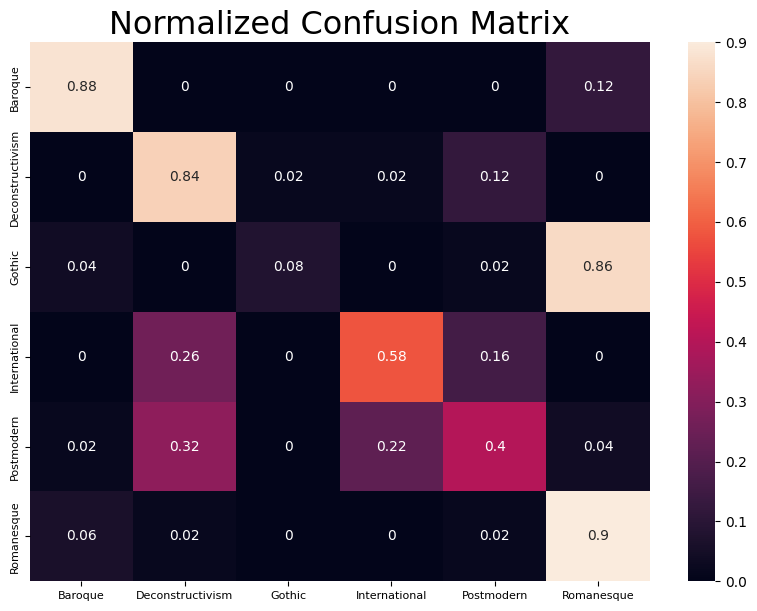

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')



plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()